<a href="https://colab.research.google.com/github/blackxhrt2102/project_related_to_medical/blob/main/Pneumonia/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:35<00:00, 48.2MB/s]
100% 1.17G/1.17G [00:35<00:00, 35.7MB/s]


In [2]:
import zipfile

data=zipfile.ZipFile('/content/labeled-chest-xray-images.zip')
data.extractall('/content')

In [3]:
import tensorflow as tf
import keras


In [4]:
model=keras.models.Sequential([
                               keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
                               keras.layers.MaxPooling2D(2,2),
                               keras.layers.Conv2D(32,(3,3),activation='relu'),
                               keras.layers.MaxPooling2D(2,2),
                               keras.layers.Conv2D(64,(3,3),activation='relu'),
                               keras.layers.MaxPooling2D(2,2),
                               keras.layers.Conv2D(128,(3,3),activation='relu'),
                               keras.layers.MaxPooling2D(2,2),
                               keras.layers.Conv2D(256,(3,3),activation='relu'),
                               keras.layers.MaxPooling2D(2,2),
                               keras.layers.Flatten(),
                               keras.layers.Dropout(0.15),
                               keras.layers.Dense(1024,activation='relu'),
                               keras.layers.Dense(1,activation='softmax')                           
])
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_d=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_d=ImageDataGenerator(
    rescale=1.0/255
)

In [13]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

model_check=ModelCheckpoint(filepath='/content/chest.h5',save_best_only=True,monitor='val_loss')
early_stop=EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1)

In [6]:
train_path=train_d.flow_from_directory('/content/chest_xray/train',target_size=(150,150),batch_size=60,class_mode='binary')
valid_path=train_d.flow_from_directory('/content/chest_xray/test',target_size=(150,150),batch_size=15,class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:
history=model.fit(train_path,steps_per_epoch=40,epochs=40,verbose='auto',validation_data=valid_path,callbacks=[model_check,early_stop,lr])

Epoch 1/40
40/40 [==============================] - 47s 1s/step - loss: 0.1313 - val_loss: 0.2844 - lr: 1.0000e-07
Epoch 2/40
40/40 [==============================] - 47s 1s/step - loss: 0.1306 - val_loss: 0.3044 - lr: 1.0000e-07
Epoch 3/40
40/40 [==============================] - 47s 1s/step - loss: 0.1246 - val_loss: 0.2950 - lr: 1.0000e-07
Epoch 4/40
40/40 [==============================] - 47s 1s/step - loss: 0.1162 - val_loss: 0.2616 - lr: 1.0000e-07
Epoch 5/40
40/40 [==============================] - 48s 1s/step - loss: 0.1196 - val_loss: 0.3071 - lr: 1.0000e-07
Epoch 6/40
40/40 [==============================] - 48s 1s/step - loss: 0.1256 - val_loss: 0.2791 - lr: 1.0000e-07
Epoch 7/40
40/40 [==============================] - 47s 1s/step - loss: 0.1131 - val_loss: 0.2925 - lr: 1.0000e-07
Epoch 8/40
40/40 [==============================] - 47s 1s/step - loss: 0.1156 - val_loss: 0.3162 - lr: 1.0000e-08
Epoch 9/40
40/40 [==============================] - 47s 1s/step - loss: 0.1248 -

In [31]:
import joblib
joblib.dump(history,'/content/model.h5')

INFO:tensorflow:Assets written to: ram://a43f52a0-ea6e-4cbb-b21d-c6533dc29d32/assets


['/content/model.h5']

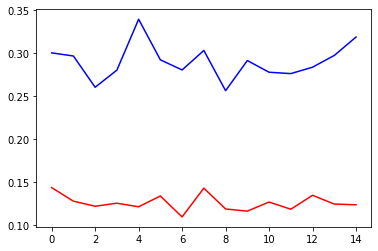

In [29]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))

import matplotlib.pyplot as plt
plt.plot(epochs,loss,color='red')
plt.plot(epochs,val_loss,color='blue')